### Data

In [1]:
from tqdm.auto import tqdm
from datasets import load_dataset
import numpy as  np
from transformers import GPT2Tokenizer

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
dataset = load_dataset('wikitext', 'wikitext-103-v1')
split = dataset['train']

In [ ]:
# compute text with token length >= 512
batch = 500
min_tok_length = 512
filtered = []
lengths = []
max_length = 0
for i in tqdm(range(0, len(split), batch)):
    lengths += [len(tok) for tok in tokenizer.batch_encode_plus([split[min(i+j, len(split) - 1)]['text'] for j in range(batch)])['input_ids']]

In [ ]:
np.save('token_length.npy', np.array(lengths))

In [3]:
l = np.load('token_length.npy')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
all([len(tok) > 512 for tok in tokenizer.batch_encode_plus([split[int(i)]['text'] for i in np.where(l > 512)[0][:20]])['input_ids']])

True

### Apply to MHA (GPT2 WikiText)

In [6]:
import torch
import torch.nn as nn
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import transformers_drop_in as drop_in
import tensor_util as tu
from config import CONFIG

In [7]:
CONFIG.do_consolidate = True
CONFIG.consolidate_ratio = 0.5
CONFIG.context_length = 400
CONFIG.consolidate_length = 200
CONFIG.temperature = 0.1
CONFIG.fix_prune_rate = True

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(CONFIG.device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2AttentionDropIn(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
batch_size = 1
indices, = np.where(l > CONFIG.context_length)
batch_iter = iter(np.array_split(np.random.choice(indices, len(indices), replace=False), len(indices) // batch_size))

In [19]:
n_layer = 12
drop_in.GLOBALS.outputs = {
    'unnormalized': [[] for _ in range(n_layer)],
    'eig': [[] for _ in range(n_layer)],
    'final': [[] for _ in range(n_layer)],
    'values': [[] for _ in range(n_layer)],
}
def record_svd(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    drop_in.GLOBALS.outputs['unnormalized'][layer_idx] += [torch.linalg.svdvals(unnormalized_attn).reshape(-1, final_attn.shape[-1]).cpu().numpy()]
    drop_in.GLOBALS.outputs['final'][layer_idx] += [torch.linalg.svdvals(final_attn).reshape(-1, final_attn.shape[-1]).cpu().numpy()]
    drop_in.GLOBALS.outputs['eig'][layer_idx] += [torch.linalg.eigvals(unnormalized_attn).reshape(-1, final_attn.shape[-1]).cpu().type(torch.float).numpy()]


def record_attn(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    drop_in.GLOBALS.outputs['unnormalized'][layer_idx] += [unnormalized_attn.cpu()]
    drop_in.GLOBALS.outputs['final'][layer_idx] += [final_attn.cpu()]
    drop_in.GLOBALS.outputs['values'][layer_idx] += [value.cpu()]


def no_op(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    pass

drop_in.record_attn_vars = record_attn

In [20]:
n_sample = 1
n_layer = 12
cols = 4
rows = n_layer // cols
rank_by_layer = [[] for _ in range(n_layer)]
with torch.no_grad():
    for i in tqdm(range(n_sample)):
        batch = next(batch_iter)
        model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                         return_tensors="pt",
                                                                                         truncation=True,
                                                                                         max_length=CONFIG.context_length).items()}
        model(**model_input)

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
for i in range(n_layer):
    for m in ['eig']:
        drop_in.GLOBALS.outputs[m][i] = np.concatenate(drop_in.GLOBALS.outputs[m][i], axis=0)

In [77]:
# svs_f = np.stack(drop_in.GLOBALS.outputs['final'], axis=1)
# svs_f = svs_f / svs_f.sum(axis=-1)[...,None]
# svs_u = np.stack(drop_in.GLOBALS.outputs['unnormalized'], axis=1)
# svs_u = svs_u / svs_u.sum(axis=-1)[...,None]
svs_e = np.stack(drop_in.GLOBALS.outputs['eig'], axis=1)
svs_e = np.abs(svs_e)
svs_e = svs_e / svs_e.sum(axis=-1)[...,None]

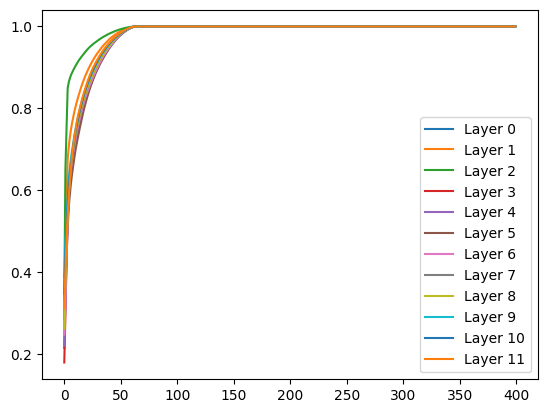

In [79]:
cumsum_e = svs_e.cumsum(axis=-1).mean(axis=0)
for i in range(n_layer):
    plt.plot(cumsum_e[i], label=f"Layer {i}")
plt.legend()

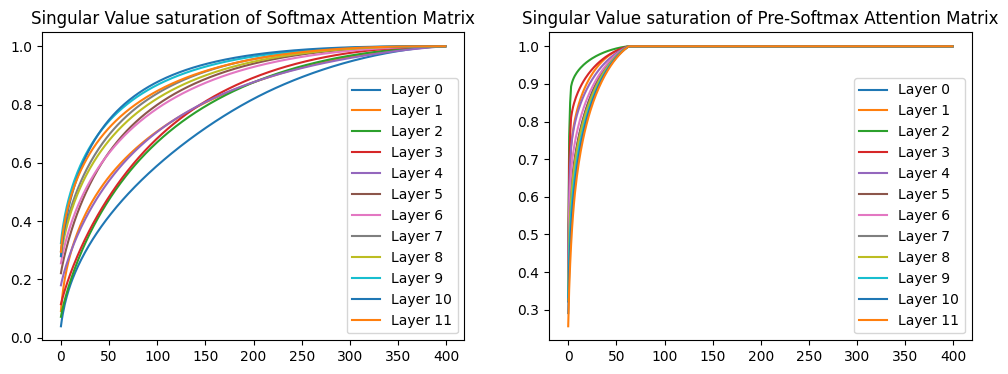

In [26]:
cumsum_f = svs_f.cumsum(axis=-1)
cumsum_f = cumsum_f.mean(axis=0)
cumsum_u = svs_u.cumsum(axis=-1)
cumsum_u = cumsum_u.mean(axis=0)
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(n_layer):
    ax[0].set_title("Singular Value saturation of Softmax Attention Matrix")
    ax[0].plot(cumsum_f[i], label=f"Layer {i}")
    ax[1].set_title("Singular Value saturation of Pre-Softmax Attention Matrix")
    ax[1].plot(cumsum_u[i], label=f"Layer {i}")
ax[0].legend()
ax[1].legend()

### Test Low-Rank SVD approximation of A

In [27]:
for m in ['final', 'unnormalized', 'values']:
    drop_in.GLOBALS.outputs[m] = torch.stack([torch.concatenate(drop_in.GLOBALS.outputs[m][i], dim=0) for i in range(n_layer)], dim=1)

In [30]:
data = drop_in.GLOBALS.outputs

In [33]:
raw = data['unnormalized'][0]
values = data['values'][0]
attn = torch.softmax(raw, dim=-1)
out = torch.matmul(attn, values)

In [143]:
# decompose A
d = 64
S, V, D = torch.svd(attn)
attn_p = S[...,:d] @ torch.diag_embed(V[...,:d].reshape(-1, d)).reshape(*S.shape[:-2], d, d) @ D[...,:d].transpose(-1, -2)
out_p = torch.matmul(attn_p, values)
error = ((out - out_p) ** 2).sum(dim=-1).mean()
error

tensor(0.8511)

### Measure effect of ppl (First 3 batches)

In [ ]:
drop_in.GLOBALS.attention_svd = 400
batch_size = 1
nlls = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(np.array_split(indices, len(indices) // batch_size))):
        model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                     return_tensors="pt",
                                                                                     truncation=True,
                                                                                     max_length=CONFIG.context_length).items()}
        labels = model_input['input_ids'].clone()
        out = model(**model_input, labels=labels)  # forward pass handles predicted token time shift
        nlls += [out.loss]
ppl = torch.exp(torch.stack(nlls).mean())

In [11]:
torch.exp(torch.stack(nlls).mean())  # d=64

tensor(91.0543, device='cuda:0')

In [13]:
torch.exp(torch.stack(nlls).mean())  # d=128

tensor(42.7846, device='cuda:0')

In [15]:
torch.exp(torch.stack(nlls).mean())  # d=200

tensor(32.2301, device='cuda:0')

In [17]:
torch.exp(torch.stack(nlls).mean())  # d=400

tensor(30.2086, device='cuda:0')

### Plot Scaling of Attention Matrix Rank with Context Length

In [9]:
n_layer = 12
drop_in.GLOBALS.outputs = {
    'rank': [[] for _ in range(n_layer)],
}
def record_rank(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    unmasked_attn = unnormalized_attn / torch.full(
        [], value.size(-1) ** 0.5, dtype=unnormalized_attn.dtype, device=unnormalized_attn.device
    )
    unmasked_attn = unmasked_attn.softmax(dim=-1)
    drop_in.GLOBALS.outputs['rank'][layer_idx] += [torch.linalg.matrix_rank(unmasked_attn)]

def no_op(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    pass

drop_in.record_attn_vars = no_op

In [13]:
context_lengths = np.arange(100, 1000, 10)
n_layer = 12
n_sample = 10
pbar = tqdm(total=(len(context_lengths) - 1) * n_sample * 2)
ppl = []
ppl_cm = []
ppl_ncm = []
with torch.no_grad():
    for i in range(len(context_lengths) - 1):
        indices, = np.where((l >= context_lengths[i]) & (l < context_lengths[i+1]))

        # batch_iter = iter(np.array_split(np.random.choice(indices, n_sample, replace=False), n_sample))
        # drop_in.GLOBALS.attention_svd = context_lengths[i] // 4
        # drop_in.GLOBALS.attention_svd_causal = False
        # nlls = []
        # for j in range(n_sample):
        #     batch = next(batch_iter)
        #     model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
        #                                                                                      return_tensors="pt",
        #                                                                                      truncation=True,
        #                                                                                      max_length=context_lengths[i]).items()}
        #     labels = model_input['input_ids'].clone()
        #     out = model(**model_input, labels=labels)
        #     nlls += [out.loss]
        #     pbar.update(1)
        # # drop_in.GLOBALS.outputs['rank'] = [
        # #     torch.stack(rank_list[-n_sample:], dim=0).cpu().numpy().mean(axis=0) for rank_list in drop_in.GLOBALS.outputs['rank']
        # # ]
        # ppl_ncm += [np.exp(torch.stack(nlls).mean().item())]
        
        batch_iter = iter(np.array_split(np.random.choice(indices, n_sample, replace=False), n_sample))
        drop_in.GLOBALS.attention_svd = 0
        nlls = []
        for j in range(n_sample):
            batch = next(batch_iter)
            model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                             return_tensors="pt",
                                                                                             truncation=True,
                                                                                             max_length=context_lengths[i]).items()}
            labels = model_input['input_ids'].clone()
            out = model(**model_input, labels=labels)
            nlls += [out.loss]
            pbar.update(1)
        # drop_in.GLOBALS.outputs['rank'] = [
        #     torch.stack(rank_list[-n_sample:], dim=0).cpu().numpy().mean(axis=0) for rank_list in drop_in.GLOBALS.outputs['rank']
        # ]
        ppl += [np.exp(torch.stack(nlls).mean().item())]
        
        batch_iter = iter(np.array_split(np.random.choice(indices, n_sample, replace=False), n_sample))
        drop_in.GLOBALS.attention_svd = context_lengths[i] // 4
        drop_in.GLOBALS.attention_svd_causal = True
        nlls = []
        for j in range(n_sample):
            batch = next(batch_iter)
            model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                             return_tensors="pt",
                                                                                             truncation=True,
                                                                                             max_length=context_lengths[i]).items()}
            labels = model_input['input_ids'].clone()
            out = model(**model_input, labels=labels)
            nlls += [out.loss]
            pbar.update(1)
        # drop_in.GLOBALS.outputs['rank'] = [
        #     torch.stack(rank_list[-n_sample:], dim=0).cpu().numpy().mean(axis=0) for rank_list in drop_in.GLOBALS.outputs['rank']
        # ]
        ppl_cm += [np.exp(torch.stack(nlls).mean().item())]


  0%|          | 0/1780 [00:00<?, ?it/s]

ValueError: Cannot take a larger sample than population when 'replace=False'

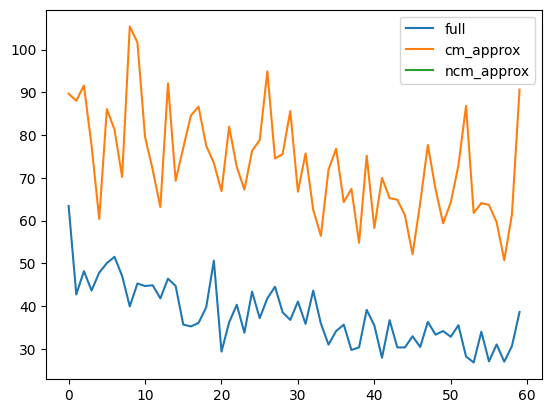

In [14]:
plt.plot(ppl, label='full')
plt.plot(ppl_cm, label='cm_approx')
plt.plot(ppl_ncm, label='ncm_approx')
plt.legend()

In [18]:
np.savez('approx_ppl.npz', full=np.stack(ppl), cm=np.stack(ppl_cm))

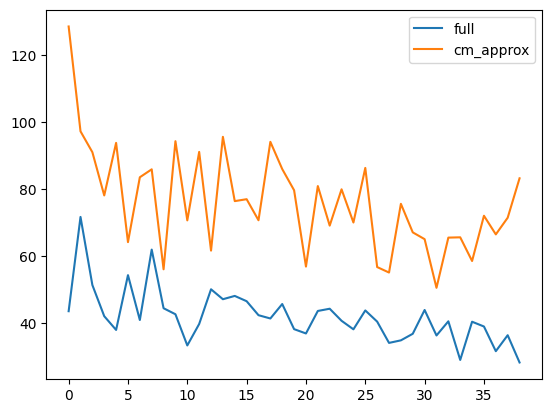

In [17]:
plt.plot(ppl, label='full')
plt.plot(ppl_cm, label='cm_approx')
#plt.plot(ppl_ncm, label='ncm_approx')
plt.legend()

Plot scaling of Attention Matrix Rank by Context Length

In [54]:
ranks = torch.stack([torch.concatenate(drop_in.GLOBALS.outputs['rank'][i], dim=0) for i in range(n_layer)], dim=0).cpu().numpy()
ranks = np.stack(np.array_split(ranks, len(context_lengths) - 1, axis=1), axis=1)  # [ n layer, n context length, n heads, n sample ]
ranks = ranks.reshape((*ranks.shape[:2], -1))
ranks.shape

(12, 8, 120)

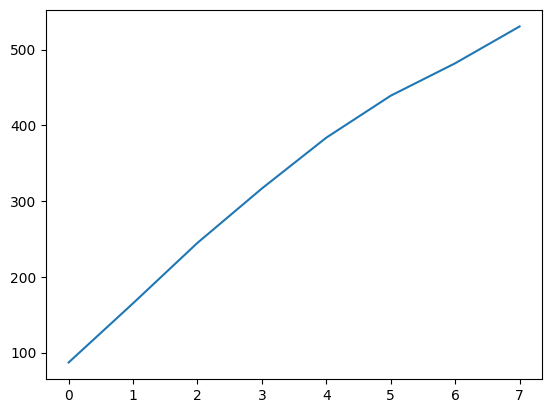

In [55]:
plt.plot(ranks.mean(axis=(0, 2)))  # non-causally-masked matrix rank by context length